# Multiclass Text Classification on Consumer Complaints for Financial Products
## Author: Georgios Spyrou
## Date: 19/08/2020

### Project Description

The data used in this project contain complaints that have been made by consumers regarding financial services and products (e.g. student loans, credit reports, mortgage, etc) in the United States between November 2011 and May 2019. Each of the complaints is marked to belong under one Product Category. This makes the data ideal for supervised learning purposes, with the text (complaint from the consumer) as the **input**, and the category that the complaint belongs to as the **target** variable.

The dataset is publicly available and it keeps getting updated daily from the USA Consumer Financial Protection Bureau, and it can be found <a href="https://catalog.data.gov/dataset/consumer-complaint-database" style="text-decoration: none"> here</a>.

After this small introduction, we can move to the main part of the project. At the beggining we will load the dataset into Python, perform some data cleaning and continue with the exploratory data analysis part, so that we can get a better understanding of the dataset. After we make sure that we understand the data, we will proceed to the modeling part where we will try different types of classification algorithms and compare their performance on predicting to which class/category each complaint should fall into.

### Part 1 - Data Loading

In [3]:
# Import dependencies
import os
import re
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
project_dir = r'C:\Users\george\Desktop\GitHub\Projects\Consumer_Complaints'
os.chdir(project_dir)

complaints_df = pd.read_csv(os.path.join(project_dir, 'Data', 'complaints.csv'))

In [9]:
complaints_df.shape

(1706612, 18)

In [5]:
complaints_df.columns

Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID'],
      dtype='object')

From the features contained in the dataset we technically only care about the columns **Consumer complaint narrative** which corresponds to the text/complaint of the consumer, and the **Product** which is the category that the complaint falls into and it will be our target variable. Please note that the input variable is going to be renamed in the next step, for ease of use.

### Part 2 - Data Cleaning & Exporatory Data Analysis

#### Initial Data Cleaning

In [7]:
# Renaming the predictor column for ease of use
complaints_df.rename(columns={'Consumer complaint narrative': 'Complaint'}, inplace=True)

In [11]:
# Get the year that the complaint took place as a separate column
complaints_df['Year'] = complaints_df['Date received'].apply(lambda x: int(re.findall('[0-9]{4}', x)[0]))
    
complaints_df.Year.value_counts()

2019    277389
2018    257312
2017    242965
2020    232834
2016    191468
2015    168475
2014    153043
2013    108217
2012     72373
2011      2536
Name: Year, dtype: int64

In [8]:
# Identify how many missing values we have per column 
complaints_df.isnull().sum(axis=0)

Date received                         0
Product                               0
Sub-product                      235165
Issue                                 1
Sub-issue                        578864
Complaint                       1130110
Company public response         1028312
Company                               0
State                             29187
ZIP code                         164485
Tags                            1478326
Consumer consent provided?       648327
Submitted via                         0
Date sent to company                  0
Company response to consumer          2
Timely response?                      0
Consumer disputed?               938135
Complaint ID                          0
dtype: int64

We can see that 1130110 out of the 1706612 complaints in the dataset are empty, which means that the consumer did not provide any text explaining the reason for raising the complaint. Thus, such cases are not very useful in our project as they provide no helpful information in order to predict to which product category they should belong based on the consumer's input.

Before we reduce the dataset to only retain the rows where the Complaint field is populated, we will continue the EDA with the whole dataset and perform this task in a later stage.

#### Exploratory Data Analysis & Visualizations

In [15]:
def plotNumberOfObservationsPerCategory(input_df: pd.core.frame.DataFrame, col: str, by_year=True, figsize=(10,8)):
    """
    Returns a countplot with the number of observations
    based on the column defined by 'col'
    """
    hue = None
    if by_year == True:
        hue = input_df['Year']
    plt.figure(figsize=figsize)
    sns.countplot(y=input_df[col], hue=hue,
                       order=input_df[col].value_counts().index)
    plt.title(f'Number of Complaints per {col} Category', fontweight="bold")
    plt.show()

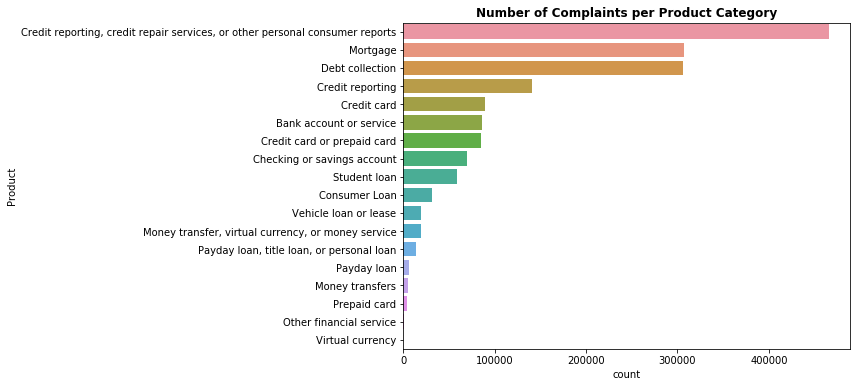

In [16]:
plotNumberOfObservationsPerCategory(complaints_df, col='Product', by_year=False, figsize=(8,6))